# Libraries and Requirments

In [ ]:
import pathlib
from typing import Any, Optional
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, InputLayer, Dropout
from kerastuner.tuners import RandomSearch
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from sklearn.model_selection import train_test_split
from keras import backend as K
from sklearn.preprocessing import OneHotEncoder
!pip install siuba # R syntax for python. Mainly the '>>' operator to work with plotnine
from siuba import *
from plotnine import * # ggplot for python
import itertools
from itertools import chain # for avoiding lists
import math # for sqrt()
import shap

print("Tensorflow version:", tf.__version__)
tf.get_logger().setLevel('ERROR')
print(0)

# Helper functions

In [ ]:
# helper function to plot the history of the dataframe
def plot_history(hist: pd.DataFrame, title="History", file_title="") -> None:
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],
           label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_accuracy'], alpha=0.5,
           label = 'Validation Accuracy')
    plt.legend()
    plt.title(title)
    plt.savefig(file_title, dpi=500)
    plt.show()
    # plt.figure()
    # plt.xlabel('Epoch')
    # plt.ylabel('Mean Square Error')
    # plt.plot(hist['epoch'], hist['mse'],
    #        label='Train Error')
    # plt.plot(hist['epoch'], hist['val_mse'],
    #        label = 'Val Error')
    # plt.legend()
    # plt.show()

In [ ]:
 def plot_confusion_matrix(cm, class_labels=None, file_title=""):
    # From DME labs
    """Plots a confusion matrix using seaborn's heatmap function
    
    Columns and rows are labelled with the strings provided in class_labels.
    
    Parameters
    ----------
    cm: array-like
        contains the confusion matrix
        
    class_labels: array-like, optional
        contains the string labels
            
    """
    # check whether we have count data or not
    if issubclass(cm.dtype.type, np.integer):
        fmt = 'd'
    else:
        fmt = '.2f'
    
    # Your code goes here
    
    if class_labels is not None:
        sns.heatmap(cm, cmap='viridis',xticklabels=class_labels, yticklabels=class_labels,\
                    annot=True, annot_kws={"fontsize":9},  fmt=fmt)  # controls the display of the numbers
    else:
        sns.heatmap(cm, annot=True, annot_kws={"fontsize":9},  fmt=fmt)
        
    plt.ylabel('True label', fontweight='bold')
    plt.xlabel('Predicted label', fontweight='bold')
    
    # you can change the appearance of the figure with lower-level matplotlib commands
    # here we rotate the labels on the x-axis
    plt.setp(plt.gca().get_xticklabels(), ha="right", rotation_mode="anchor")
    plt.savefig(file_title, dpi=500)

In [ ]:
# Normalization helper function
def norm(x: pd.DataFrame) -> pd.DataFrame:
    return(x - train_stats['mean'] / train_stats['std'])

In [ ]:
def calc_entropy(col):
    entropy = - sum([ p * math.log2(p) for p in col])
    return entropy

# Data splits

In [ ]:
raw_wine = pd.read_csv('../input/wine2csv/wine.csv')

# taking a copy
dataset = raw_wine.copy()

# one hot encoding the type
quality = dataset.pop('quality')
dataset['quality_3'] = (quality == 3)*1.0
dataset['quality_4'] = (quality == 4)*1.0
dataset['quality_5'] = (quality == 5)*1.0
dataset['quality_6'] = (quality == 6)*1.0
dataset['quality_7'] = (quality == 7)*1.0
dataset['quality_8'] = (quality == 8)*1.0
dataset['quality_9'] = (quality == 9)*1.0


# setting the X matrix and y vector.
X_full = dataset.loc[ : , dataset.columns != 'type']
y_full = dataset.loc[ : , dataset.columns == 'type']
# pd.to_numeric(y_full.type) # for sparse_categorical_cross_entropy
y_full = OneHotEncoder(sparse=False).fit_transform(dataset[["type"]].values) # for categorical_cross_entropy

# Model splits
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.2, random_state=1903)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1903) # 0.25 * (1-0.2) = 0.2

# bug checking splits
# X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.99, random_state=1903)
# X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.25, random_state=1903) # 0.25 * (1-0.2) = 0.2

# Normalizing 
train_stats = X_train.describe().transpose()
X_train = norm(X_train)
X_val = norm(X_val)
X_test = norm(X_test)

# train_set = pd.concat([X_train, y_train], axis=1)
# test_set  = pd.concat([X_test , y_test ], axis=1)

### Epoch Levers

In [ ]:
train_epochs = 2000
search_epochs = 5
ealry_stop_pat = 200

# Modeling

## Hyper parameter tuning Helper Functions

In [ ]:
def nll(y_true, y_pred):
    """ Negative log likelihood. """

    # keras.losses.binary_crossentropy give the mean
    # over the last axis. we require the sum
    return K.sum(K.categorical_crossentropy(y_true, y_pred), axis=-1)

### Base

In [ ]:
# Base model 
def model_baseline_hp(hp):
    K.clear_session()
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=18)) # input layer
    
    # ------------------------------------------------------------
    for i in range(hp.Int('layers', 2, 6)): # number or layers treated as a hyper parameter
        model.add(keras.layers.Dense(hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=128),
                                     activation=hp.Choice('act_' + str(i),
                                                          ['relu', 'sigmoid', 'elu'])))
        # model.add(keras.layers.Dropout(hp.Choice('drop_' + str(i), [0.2, 0.5, 0.7, 0.9])))
    
    # ------------------------------------------------------------
    # model.add(keras.layers.Dense(1, activation='linear')) # output layer for regression
    model.add(keras.layers.Dense(3, activation='softmax')) # output layer for classification

    
    # compile the model
    optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]))
    model.compile(optimizer=optimizer,
                  loss=nll,
                  metrics=['accuracy'])
    return model

We illustrate a Bayesian neural network with variational inference, assuming a dataset of features and labels.

It uses the Flipout gradient estimator to minimize the Kullback-Leibler divergence up to a constant, also known as the negative Evidence Lower Bound. It consists of the sum of two terms: the expected negative log-likelihood, which we approximate via Monte Carlo; and the KL divergence, which is added via regularizer terms which are arguments to the layer.

References
[1]: Yeming Wen, Paul Vicol, Jimmy Ba, Dustin Tran, and Roger Grosse. Flipout: Efficient Pseudo-Independent Weight Perturbations on Mini-Batches. In International Conference on Learning Representations, 2018. https://arxiv.org/abs/1803.04386



### Fliptout

In [ ]:
# Bayesian model with flipout layer
def model_bayesian_hp_flipout(hp):
    K.clear_session()
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=18)) # input layer
    model.add(tfp.layers.DenseFlipout(hp.Int('flip_units',
                                                 min_value=32,
                                                 max_value=512,
                                                 step=128),
                                          activation=hp.Choice('flip_act', ['relu', 'sigmoid', 'elu'])))
    
    # -------------------------------------------------------------------------------------------
    for i in range(hp.Int('layers', 2, 8)): # number or layers treated as a hyper parameter
        model.add(keras.layers.Dense(hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=128),
                                     activation=hp.Choice('act_' + str(i),
                                                          ['relu', 'sigmoid', 'elu'])))
        # model.add(keras.layers.Dropout(hp.Choice('drop_' + str(i), [0.2, 0.5, 0.7, 0.9])))
    # -------------------------------------------------------------------------------------------
    
    # model.add(keras.layers.Dense(1, activation='linear')) # output layer for regression
    model.add(tfp.layers.DenseFlipout(3, activation='softmax')) # output layer for classification

    
    # compile the model
    optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', [1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]))
    model.compile(optimizer=optimizer,
                  loss=nll,
                  metrics=['accuracy'])
    return model

------------------
### Variational

In [ ]:
# Multivariate Normal zero one prior
def prior_trainable(kernel_size: int, bias_size: int, dtype: Any) -> tf.keras.Model:
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t, scale=1),
            reinterpreted_batch_ndims=1)),
    ])

# Therefore, theory tells us that the posterior is also Multivariate Normal
def posterior_mean_field(kernel_size: int, bias_size: int, dtype: Any) -> tf.keras.Model:
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n],
                      scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
        reinterpreted_batch_ndims=1)),
    ])

In [ ]:
# Bayesian model with variational layer 
def model_bayesian_hp_variational(hp):
    K.clear_session()
    model = keras.Sequential()
    model.add(tfp.layers.DenseVariational(hp.Int('var_units',
                                                 min_value=32,
                                                 max_value=512,
                                                 step=128),
                                          activation=hp.Choice('var_act', ['relu', 'sigmoid', 'elu']),
                                          input_shape=[len(X_train.keys())],
                                          make_posterior_fn=posterior_mean_field, 
                                          make_prior_fn=prior_trainable, 
                                          kl_weight=1/X_train.shape[0]))

    # -------------------------------------------------------------------------------------------
    for i in range(hp.Int('layers', 2, 6)): # number or layers treated as a hyper parameter
        model.add(keras.layers.Dense(hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=128),
                                     activation=hp.Choice('act_' + str(i),
                                                          ['relu', 'sigmoid', 'elu'])))
        # model.add(keras.layers.Dropout(hp.Choice('drop_' + str(i), [0.2, 0.5, 0.7, 0.9])))
    # -------------------------------------------------------------------------------------------

    # model.add(keras.layers.Dense(1, activation='linear')) # output layer for regression
    model.add(keras.layers.Dense(3, activation='softmax')) # output layer for classification ## 


    # compile the model
    optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', [1e-3, 1e-4, 1e-5, 1e-6, 1e-7]))
    model.compile(optimizer=optimizer,
                  loss=nll,
                  metrics=['accuracy'])
    return model

In [ ]:
# Overwrite the Dropout layer
class MCDropout(Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [ ]:
# MCdropout layer model 
def model_mcdropout_hp(hp):
    K.clear_session()
    model = keras.Sequential()
    model.add(keras.layers.Input(shape=18)) # input layer
    
    # ------------------------------------------------------------
    for i in range(hp.Int('layers', 2, 6)): # number or layers treated as a hyper parameter
        model.add(keras.layers.Dense(hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=128),
                                     activation=hp.Choice('act_' + str(i),
                                                          ['relu', 'sigmoid', 'elu'])))
        model.add(MCDropout(hp.Choice('mcdrop_' + str(i), [0.3, 0.5, 0.7, 0.9])))
    
    # ------------------------------------------------------------
    # model.add(keras.layers.Dense(1, activation='linear')) # output layer for regression
    model.add(keras.layers.Dense(3, activation='softmax')) # output layer for classification

    
    # compile the model
    optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]))
    model.compile(optimizer=optimizer,
                  loss=nll,
                  metrics=['accuracy'])
    return model

------------------------
### Base model

In [ ]:
tuner = RandomSearch(model_baseline_hp,
                     objective='val_accuracy',
                     max_trials=10,
                     executions_per_trial=2,
                     directory='rand_search_outputs',
                     project_name='base_model')
tuner.search_space_summary()

In [ ]:
tuner.search(X_train, y_train, epochs=search_epochs,
             validation_data=(X_val, y_val))
tuner.results_summary()

In [ ]:
tuner.get_best_hyperparameters()[0].values

In [ ]:
best_base_model = tuner.get_best_models()[0]

In [ ]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=ealry_stop_pat)

In [ ]:
history_base = best_base_model.fit(x=X_train,
                                   y=y_train,
                                   epochs=train_epochs,
                                   batch_size=len(X_train),
                                   verbose=0,
                                   validation_split=0.2,
                                   callbacks=[early_stop])

------------------------
### Variational

In [ ]:
tuner_var = RandomSearch(model_bayesian_hp_variational,
                     objective='val_accuracy',
                     max_trials=10,
                     executions_per_trial=2,
                     directory='rand_search_outputs',
                     project_name='variational_model')
tuner_var.search_space_summary()

In [ ]:
tuner_var.search(X_train, y_train, epochs=search_epochs,
             validation_data=(X_val, y_val))
tuner_var.results_summary()

In [ ]:
tuner_var.get_best_hyperparameters()[0].values

In [ ]:
best_var_model = tuner_var.get_best_models()[0]

In [ ]:
history_var = best_var_model.fit(x=X_train,
                                 y=y_train,
                                 epochs=train_epochs,
                                 batch_size=32,
                                 verbose=0,
                                 validation_split=0.2,
                                 callbacks=[early_stop])

------------------------
### Flipout

In [ ]:
tuner_flip = RandomSearch(model_bayesian_hp_flipout,
                     objective='val_accuracy',
                     max_trials=10,
                     executions_per_trial=2,
                     directory='rand_search_outputs',
                     project_name='fliptout_model')
tuner_flip.search_space_summary()

In [ ]:
tuner_flip.search(X_train, y_train, epochs=search_epochs,
             validation_data=(X_val, y_val))
tuner_flip.results_summary()

In [ ]:
tuner_flip.get_best_hyperparameters()[0].values

In [ ]:
best_flip_model = tuner_flip.get_best_models()[0]

In [ ]:
history_flip = best_flip_model.fit(x=X_train,
                    y=y_train,
                    epochs=train_epochs,
                    batch_size=len(X_train),
                    verbose=0,
                    validation_split=0.2,
                    callbacks=[early_stop])

----------------------
### MCDropout

In [ ]:
tuner_mcdrop = RandomSearch(model_mcdropout_hp,
                     objective='val_accuracy',
                     max_trials=10,
                     executions_per_trial=2,
                     directory='rand_search_outputs',
                     project_name='mcdrop_model')
tuner_mcdrop.search_space_summary()

In [ ]:
tuner_mcdrop.search(X_train, y_train, epochs=search_epochs,
             validation_data=(X_val, y_val))
tuner_mcdrop.results_summary()

In [ ]:
tuner_mcdrop.get_best_hyperparameters()[0].values

In [ ]:
best_mcdrop_model = tuner_mcdrop.get_best_models()[0]

In [ ]:
history_mcdrop = best_mcdrop_model.fit(x=X_train,
                                       y=y_train,
                                       epochs=train_epochs,
                                       batch_size=len(X_train),
                                       verbose=0,
                                       validation_split=0.2,
                                       callbacks=[early_stop])

### Histories

In [ ]:
best_base_model.summary()

In [ ]:
hist = pd.DataFrame(history_base.history)
hist['epoch'] = history_base.epoch
plot_history(hist, title='Base Model History', file_title='a.history-base.pdf')

In [ ]:
best_var_model.summary()

In [ ]:
hist = pd.DataFrame(history_var.history)
hist['epoch'] = history_var.epoch
h2 = plot_history(hist, title='Variational Layer Model History', file_title='b.history-var.pdf')

In [ ]:
best_flip_model.summary()

In [ ]:
hist_flip = pd.DataFrame(history_flip.history)
hist_flip['epoch'] = history_flip.epoch
h3 = plot_history(hist_flip, title='Flipout layer History', file_title='c.history-flip.pdf')

In [ ]:
best_mcdrop_model.summary()

In [ ]:
hist_mcdrop = pd.DataFrame(history_mcdrop.history)
hist_mcdrop['epoch'] = history_mcdrop.epoch
h4 = plot_history(hist_mcdrop, title='MCdropout layer History', file_title='d.history-mcdrop.pdf')

# Model Validation

In [ ]:
from sklearn.metrics import confusion_matrix

p_base = best_base_model.predict(X_val)
cf_mat_base = confusion_matrix(np.argmax(y_val, axis=1),
                 np.argmax(p_base, axis=1))
plot_confusion_matrix(cf_mat_base, class_labels=[1, 2, 3], file_title='e.confmat-base.pdf')

In [ ]:
p_var = best_var_model.predict(X_val)
cf_mat_var = confusion_matrix(np.argmax(y_val, axis=1),
                 np.argmax(p_var, axis=1))
plot_confusion_matrix(cf_mat_var, class_labels=[1, 2, 3], file_title='f.confmat-var.pdf')

In [ ]:
p_flip = best_flip_model.predict(X_val)
cf_mat_flip = confusion_matrix(np.argmax(y_val, axis=1),
                 np.argmax(p_flip, axis=1))
plot_confusion_matrix(cf_mat_flip, class_labels=[1, 2, 3], file_title='g.confmat-flip.pdf')

In [ ]:
p_mcdrop = best_mcdrop_model.predict(X_val)
cf_mat_mcdrop = confusion_matrix(np.argmax(y_val, axis=1), 
                                 np.argmax(p_mcdrop, axis=1))
plot_confusion_matrix(cf_mat_mcdrop, class_labels=[1, 2, 3], file_title='h.confmat-mcdrop.pdf')

The traditional NN works better, but within the Bayesian approaches, the MCdropout works best

# Model Explanation

In [90]:
# Select the best model for the analysis
model = best_mcdrop_model

In [ ]:
# calculate SHAP values
explainer = shap.KernelExplainer(model.predict, X_test)
shap_values = explainer.shap_values(X_test[:200], nsamples=100)

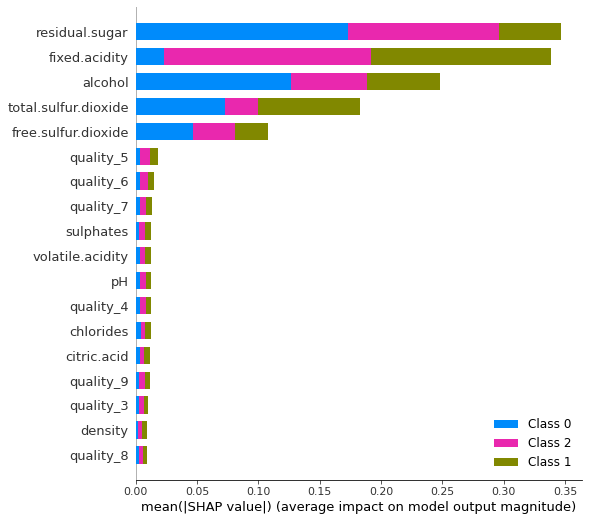

In [94]:
# Plot summary
shap.summary_plot(shap_values, X_test[:200], feature_names=X_test.columns, plot_type="bar", show=False)
plt.savefig('i.shap-summary.pdf', dpi=500)

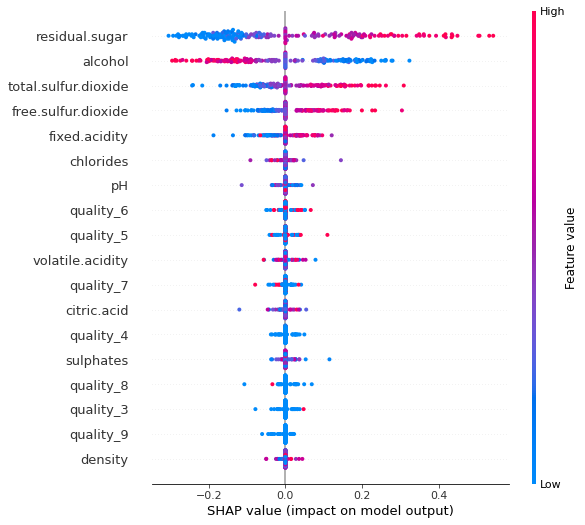

In [95]:
# Plot Summary for class 0
shap.summary_plot(shap_values[0], X_test[:200], feature_names=X_test.columns, show=False)
plt.savefig('j.shap-class0.pdf', dpi=500)

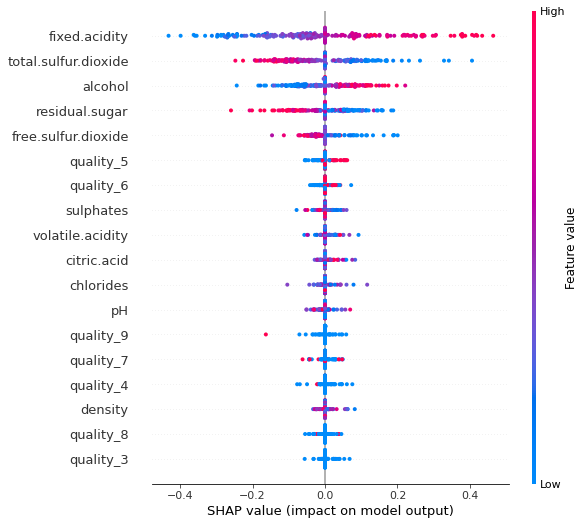

In [96]:
# Plot Summary for class 1
shap.summary_plot(shap_values[1], X_test[:200], feature_names=X_test.columns, show=False)
plt.savefig('k.shap-class1.pdf', dpi=500)

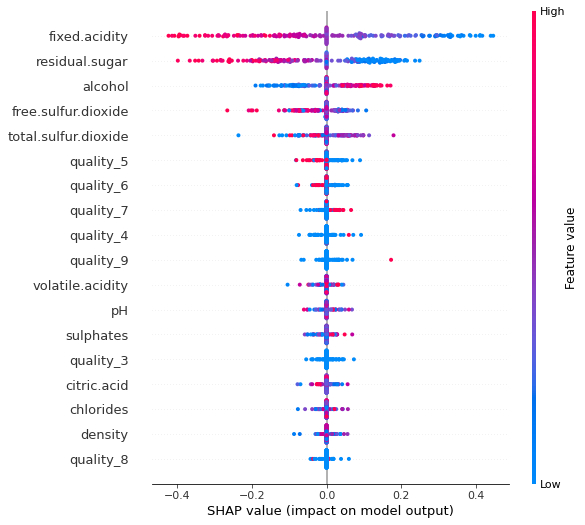

In [97]:
# Plot Summary for class 2
shap.summary_plot(shap_values[2], X_test[:200], feature_names=X_test.columns, show=False)
plt.savefig('l.shap-class2.pdf', dpi=500)

# MCMC Sampling

https://github.com/zacharyaanglin/ProbabilisticDeepLearningTensorFlow/blob/master/2%20-%20Simple%20linear%20regression%20in%20Keras%20with%20uncertainty.ipynb

https://colab.research.google.com/drive/149Wg0uB0x1ZrPDMme8gyOnlsgHC9JM6M?hl=en&pli=1#scrollTo=Bxhbrf1R1UPE

In [ ]:
# draw predictions n times
n_samples = 1000
yhats = [model.predict(X_test) for _ in range(n_samples)]
n_set = X_test.shape[0]

In [ ]:
# fix format of output
yhat_samples = pd.DataFrame(list(itertools.chain.from_iterable(yhats)))

In [ ]:
# fix format of output
yhat_samples = []
for i in range(n_samples):
    yhat_samples.extend(yhats[i])
yhat_samples = pd.DataFrame(yhat_samples)

In [ ]:
# create id columns for validation number and sample number
id_col = list(range(n_set)) # validation set number
samples_col = np.repeat(np.arange(n_samples), n_set, axis=0) # sample number

In [ ]:
# add extra columns and format
yhat_samples["id"] = id_col*n_samples
id_col = yhat_samples.pop("id")
yhat_samples.insert(0, "val_id", id_col)
yhat_samples.insert(1, "sam_id", samples_col)
yhat_samples.insert(5, "true_1", pd.DataFrame(list(y_val)*n_samples)[0])
yhat_samples.insert(6, "true_2", pd.DataFrame(list(y_val)*n_samples)[1])
yhat_samples.insert(7, "true_3", pd.DataFrame(list(y_val)*n_samples)[2])
yhat_samples.columns = ['val_id', 'sam_id', 'pred_1', 'pred_2', 'pred_3', 'true_1', 'true_2', 'true_3'] # rename column names

In [93]:
# yhat_samples['Entropy'] = -(values*np.log(values))
entropies = pd.DataFrame(yhat_samples.groupby('val_id')[['pred_1', 'pred_2', 'pred_3']].mean())
shannon = entropies.loc[:,'pred_1':'pred_3'].apply(calc_entropy,axis=1)
entropies['entropy'] = shannon
top_10 = entropies.sort_values("entropy", ascending=False).head(10)
top_10_inx = top_10.index
top_10

,pred_1,pred_2,pred_3,entropy
val_id,,,,
47,0.328992,0.315585,0.355423,1.583194
297,0.349897,0.300624,0.349479,1.581428
859,0.365646,0.295755,0.338599,1.579535
530,0.297783,0.307171,0.395046,1.572828
83,0.375284,0.351102,0.273614,1.572408
733,0.274855,0.386254,0.338891,1.571257
846,0.414156,0.295297,0.290546,1.564447
282,0.297494,0.278272,0.424235,1.558675
971,0.334237,0.422112,0.243652,1.550027


In [ ]:
confidence = yhat_samples >> group_by(_.val_id) >> mutate(avg_1 = _.pred_1.mean(),
                                                          avg_2 = _.pred_2.mean(),
                                                          avg_3 = _.pred_3.mean(),
                                                          std_1 = _.pred_1.std(),
                                                          std_2 = _.pred_2.std(),
                                                          std_3 = _.pred_3.std(),
                                                          ci_95_l_1 = _.avg_1-1.96*_.pred_1.std(),
                                                          ci_95_h_1 = _.avg_1+1.96*_.pred_2.std(),
                                                          ci_95_l_2 = _.avg_2-1.96*_.pred_3.std(),
                                                          ci_95_h_2 = _.avg_2+1.96*_.pred_1.std(),
                                                          ci_95_l_3 = _.avg_3-1.96*_.pred_2.std(),
                                                          ci_95_h_3 = _.avg_3+1.96*_.pred_3.std(),
                                                          diff_ci_1 = _.ci_95_h_1 - _.ci_95_l_1,
                                                          diff_ci_2 = _.ci_95_h_2 - _.ci_95_l_2,
                                                          diff_ci_3 = _.ci_95_h_3 - _.ci_95_l_3) >> filter(_.sam_id==0)


In [ ]:
pred_ci = confidence[['true_1', 'true_2', 'true_3',
                      'avg_1', 'avg_2', 'avg_3',
                      'ci_95_l_1', 'ci_95_h_1',
                      'ci_95_l_2', 'ci_95_h_2',
                      'ci_95_l_3', 'ci_95_h_3',
                      'std_1', 'std_2', 'std_3',
                      'diff_ci_1', 'diff_ci_2', 'diff_ci_3']]
pred_ci

Function for entropy as anomaly measure